In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import gc
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from pyarrow.parquet import ParquetFile
import pyarrow as pa 

import torch
from torch.utils.data import Dataset, DataLoader

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/child-mind-institute-detect-sleep-states/train_series.parquet
/kaggle/input/child-mind-institute-detect-sleep-states/sample_submission.csv
/kaggle/input/child-mind-institute-detect-sleep-states/train_events.csv
/kaggle/input/child-mind-institute-detect-sleep-states/test_series.parquet


## Load

# PATHs: Assumption of variables to define the input datasets

In [2]:
class PATHS:
    MAIN_DIR = "/kaggle/input/child-mind-institute-detect-sleep-states/"
    # CSV FILES : 
    SUBMISSION = MAIN_DIR + "sample_submission.csv"
    TRAIN_EVENTS = MAIN_DIR + "train_events.csv"
    # PARQUET FILES:
    TRAIN_SERIES = MAIN_DIR + "train_series.parquet"
    TEST_SERIES = MAIN_DIR + "test_series.parquet"

## Configuration: 
CFG () class defines the debug mode, verbose level, batch size and device type.

In [3]:
class CFG:
    DEMO_MODE = True
    VERBOSE = True
    
    BATCH_SIZE = 32
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## ***Preprocessing of Input Datasets***
### CMIDataReader - Child Mind Institute input dataset reader

In [4]:
class CMIDataReader:
    def __init__(self, demo_mode, verbose):
        super().__init__()
        # MAPPING FOR DATA LOADING :
        self.names_mapping = {
            "submission" : {"path" : PATHS.SUBMISSION, "is_parquet" : False, "has_timestamp" : False}, 
            "train_events" : {"path" : PATHS.TRAIN_EVENTS, "is_parquet" : False, "has_timestamp" : True},
            "train_series" : {"path" : PATHS.TRAIN_SERIES, "is_parquet" : True, "has_timestamp" : True},
            "test_series" : {"path" : PATHS.TEST_SERIES, "is_parquet" : True, "has_timestamp" : True}
        }
        self.valid_names = ["submission", "train_events", "train_series", "test_series"]
        self.demo_mode = demo_mode
        self.verbose = verbose
    
    def verify(self, data_name):
        "function for data name verification"
        if data_name not in self.valid_names:
            print("PLEASE ENTER A VALID DATASET NAME, VALID NAMES ARE : ", valid_names)
        return
    
    def cleaning(self, data):
        "cleaning function : drop na values"
        before_cleaning = len(data)
        if self.verbose:
            print("Number of missing timestamps : ", len(data[data["timestamp"].isna()]))
        data = data.dropna(subset=["timestamp"])
        after_cleaning = len(data)
        if self.verbose:
            print("Percentage of removed rows : {:.1f}%".format(100 * (before_cleaning - after_cleaning) / before_cleaning) )
        data = data.bfill()
        return data
    
    def reduce_memory_usage(self, data):
        "iterate through all the columns of a dataframe and modify the data type to reduce memory usage."
        start_mem = data.memory_usage().sum() / 1024**2
        if self.verbose:
            print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        for col in data.columns:
            col_type = data[col].dtype    
            if col_type != object:
                c_min = data[col].min()
                c_max = data[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        data[col] = data[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        data[col] = data[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        data[col] = data[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        data[col] = data[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        data[col] = data[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        data[col] = data[col].astype(np.float32)
                    else:
                        data[col] = data[col].astype(np.float64)
            else:
                data[col] = data[col].astype('category')

        end_mem = data.memory_usage().sum() / 1024**2
        if self.verbose:
            print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
            print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        return data
    
    def load_data(self, data_name):
        "function for data loading"
        self.verify(data_name)
        data_props = self.names_mapping[data_name]
        if data_props["is_parquet"]:
            if self.demo_mode:
                pf = ParquetFile(data_props["path"]) 
                demo_rows = next(pf.iter_batches(batch_size=100_000)) 
                data = pa.Table.from_batches([demo_rows]).to_pandas()
            else:
                data = pd.read_parquet(data_props["path"])
        else:
            if self.demo_mode:
                data = pd.read_csv(data_props["path"], nrows=100_000)
            else:
                data = pd.read_csv(data_props["path"])
        
        if data_props["has_timestamp"]:
            data = self.cleaning(data)
            data["timestamp"] = pd.to_datetime(data["timestamp"])
            data = data.set_index("timestamp")
        
        data = self.reduce_memory_usage(data)
        gc.collect()
        return data

### Preprocessing and input dataset reader

In [5]:
reader = CMIDataReader(demo_mode=CFG.DEMO_MODE, verbose=CFG.VERBOSE)

### Printing all the input datasets

In [6]:
print("="*25)
print("LOAD SUBMISSION")
submission = reader.load_data("submission")
print(submission.head(10))
print("LOADING FINISHED ! ")
print("="*25)

print("LOAD TEST SERIES")
test_series = reader.load_data("test_series")
print(test_series.head(10))
print("LOADING FINISHED ! ")
print("="*25)

print("="*25)
print("LOAD TRAIN SERIES")
train_series = reader.load_data("train_series")
print(train_series.head(10))
print("LOADING FINISHED ! ")
print("="*25)

print("="*25)
print("LOAD TRAIN EVENTS")
train_events = reader.load_data("train_events")
print(train_events.head(10))
print("LOADING FINISHED ! ")
print("="*25)

LOAD SUBMISSION
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -14.1%
   row_id     series_id  step   event  score
0       0  038441c925bb   100   onset    0.0
1       1  038441c925bb   105  wakeup    0.0
2       2  03d92c9f6f8a    80   onset    0.5
3       3  03d92c9f6f8a   110  wakeup    0.5
4       4  0402a003dae9    90   onset    1.0
5       5  0402a003dae9   120  wakeup    1.0
LOADING FINISHED ! 
LOAD TEST SERIES
Number of missing timestamps :  0
Percentage of removed rows : 0.0%
Memory usage of dataframe is 0.01 MB
Memory usage after optimization is: 0.01 MB
Decreased by 45.4%
                              series_id  step    anglez      enmo
timestamp                                                        
2018-08-14 15:30:00-04:00  038441c925bb   0.0  2.636719  0.021698
2018-08-14 15:30:05-04:00  038441c925bb   1.0  2.636719  0.021500
2018-08-14 15:30:10-04:00  038441c925bb   2.0  2.636719  0.021606
2018-08-14 15:30:15-04:00  038441

## Child Mind Institute Data Visualizer

In [7]:
class CMIDataVisualizer:
    
    def __init__(self, series_data, events_data):
        self.series_data = series_data
        self.events_data = events_data
    
    def plot_events(self, series_id, night_id):
        query_series = self.series_data[self.series_data.series_id == series_id]
        query_events = self.events_data[(self.events_data.series_id == series_id) \
                                       & (self.events_data.night == night_id)]["event"]
        
        _, axes = plt.subplots(2,1, figsize = (20,8))
        for t in range(len(query_events)):
            if query_events.values[t] == "onset":
                axes[1].axvline(query_events.index[t], linestyle="--", color="black")
                axes[1].annotate(
                    "Onset: {}".format(query_events.index[t].strftime("%Y-%m-%d %H:%M:%S")),
                    xy=(query_events.index[t], axes[1].get_ylim()[1]),
                    xytext=(10, 18),
                    textcoords="offset points",
                    fontsize=10,
                    color="black",
                )

            if query_events.values[t] == "wakeup":
                axes[1].axvline(query_events.index[t], linestyle="--", color="blue")
                axes[1].annotate(
                    "Wakeup: {}".format(query_events.index[t].strftime("%Y-%m-%d %H:%M:%S")),
                    xy=(query_events.index[t], axes[1].get_ylim()[1]),
                    xytext=(10, -5),
                    textcoords="offset points",
                    fontsize=10,
                    color="blue",
                )
        axes[0].plot(train_series.enmo)
        axes[0].set_ylabel("enmo")
        axes[1].plot(train_series.anglez)
        axes[1].set_ylabel("anglez")
        axes[1].legend()
        axes[0].set_title("series id : {} / night id : {}".format(series_id, night_id), size=20)
        plt.legend()
        plt.show()

### Visualize the first series id dataset mappings for the 5 nights  

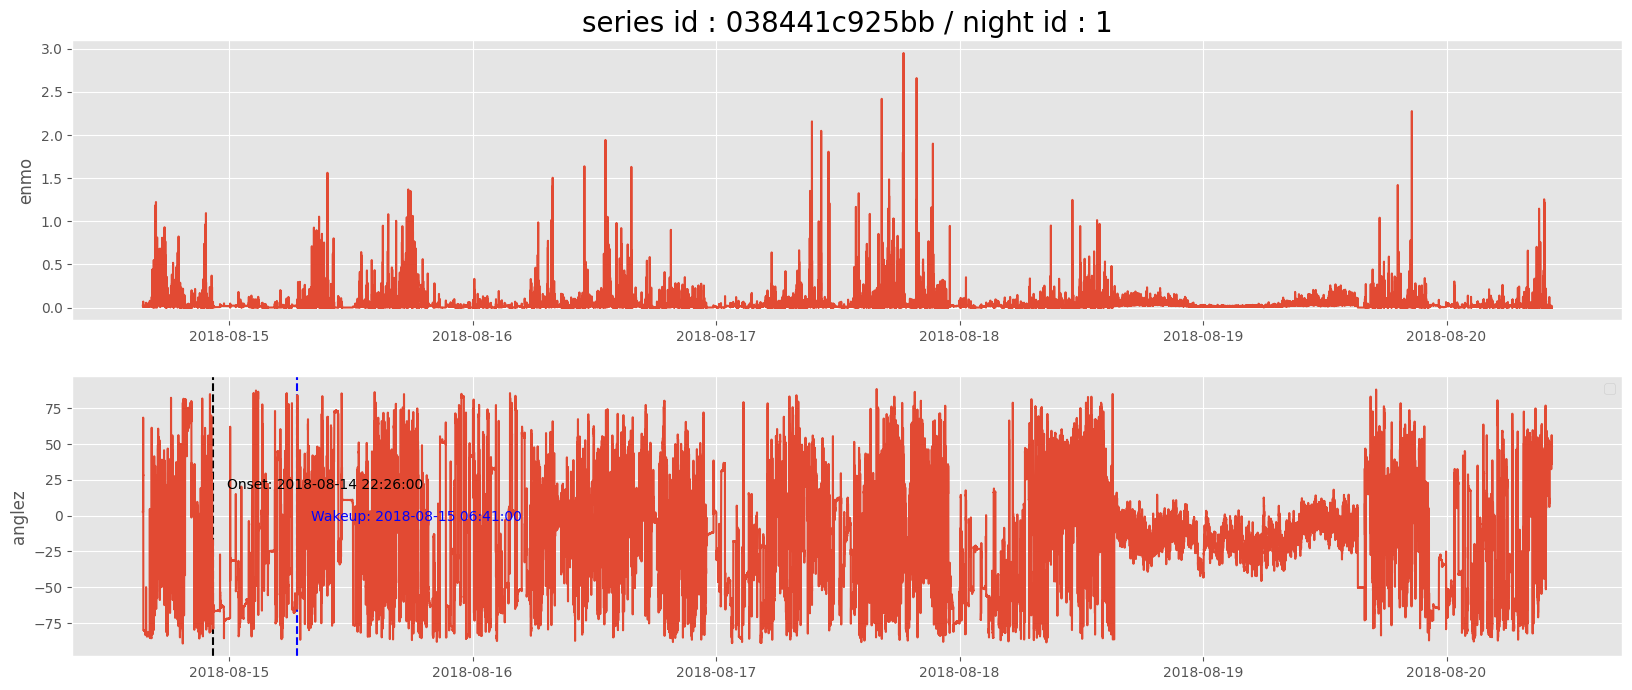

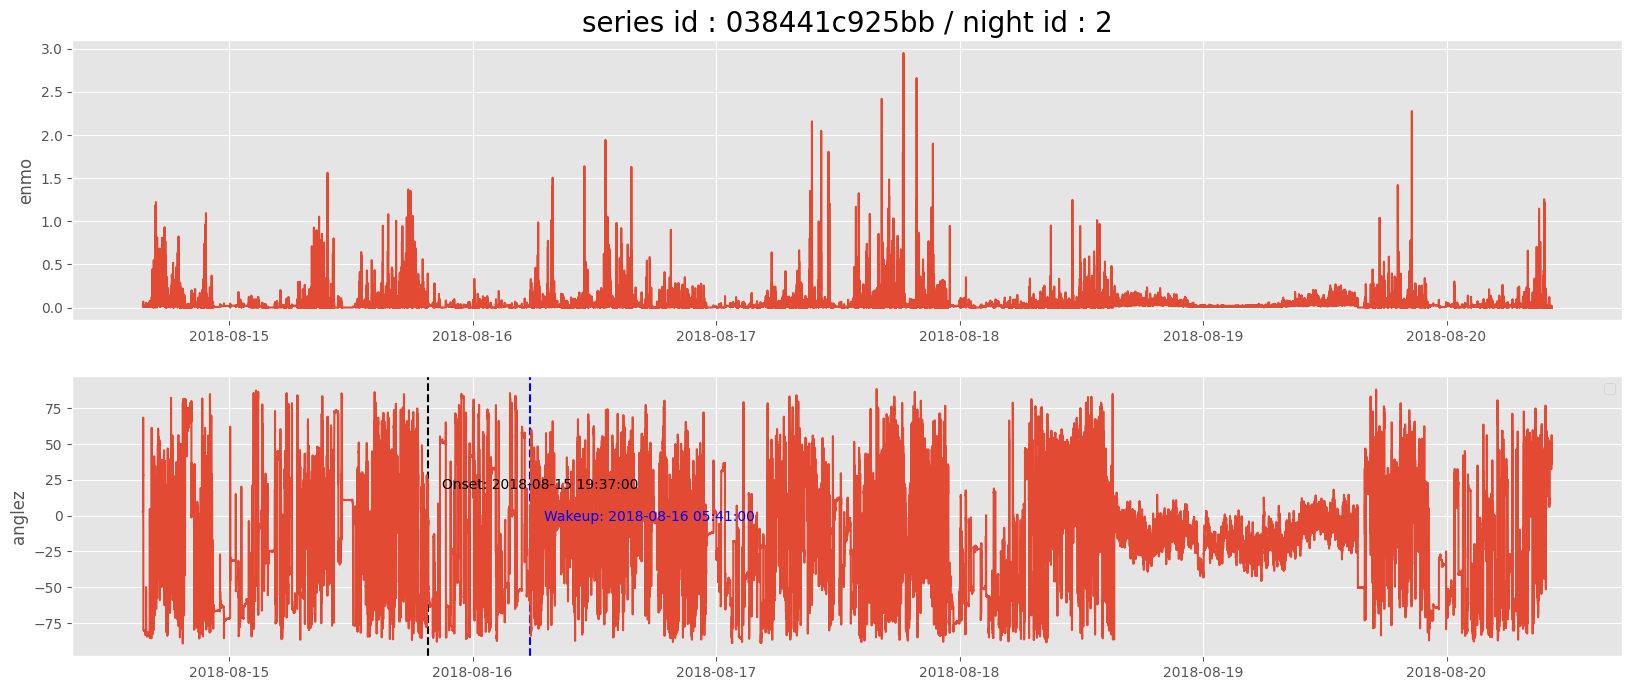

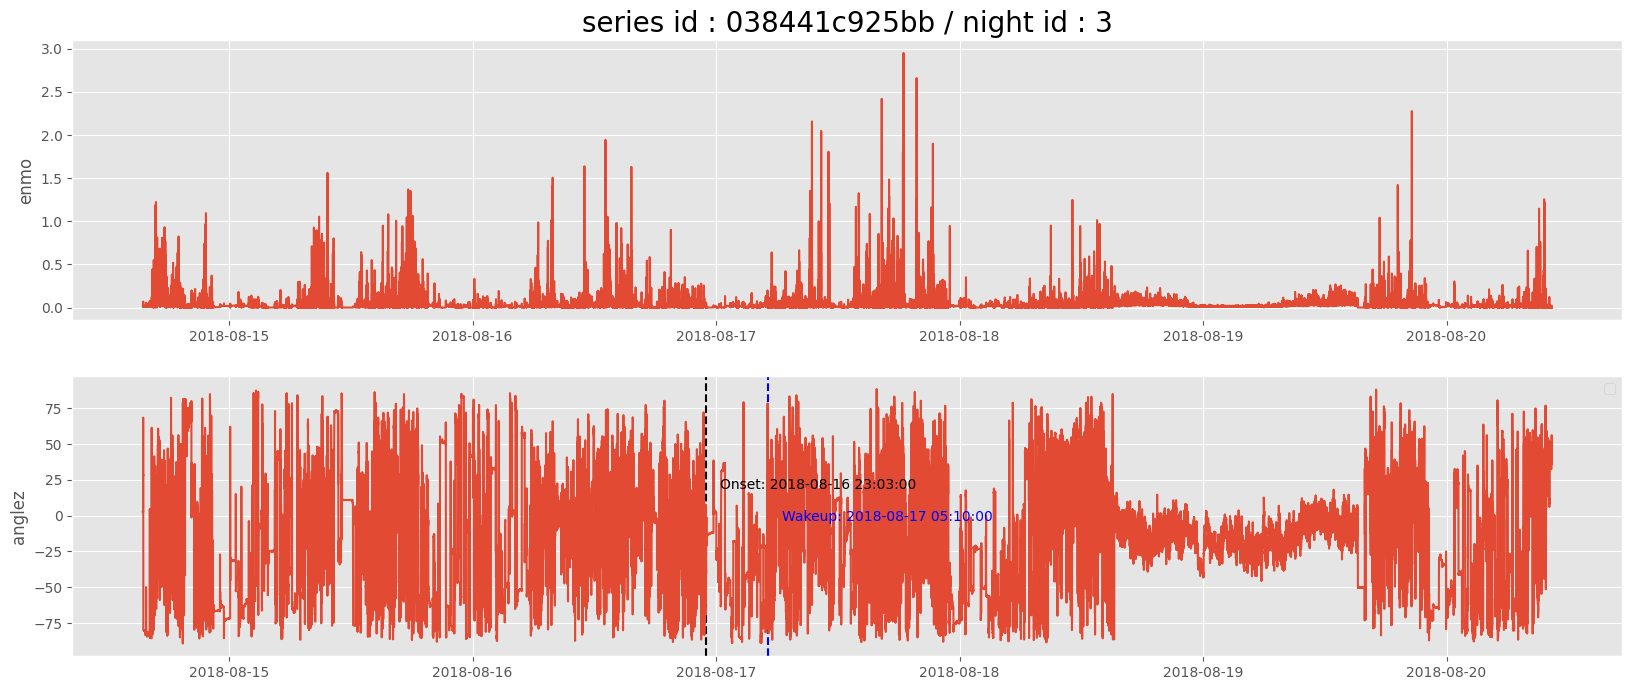

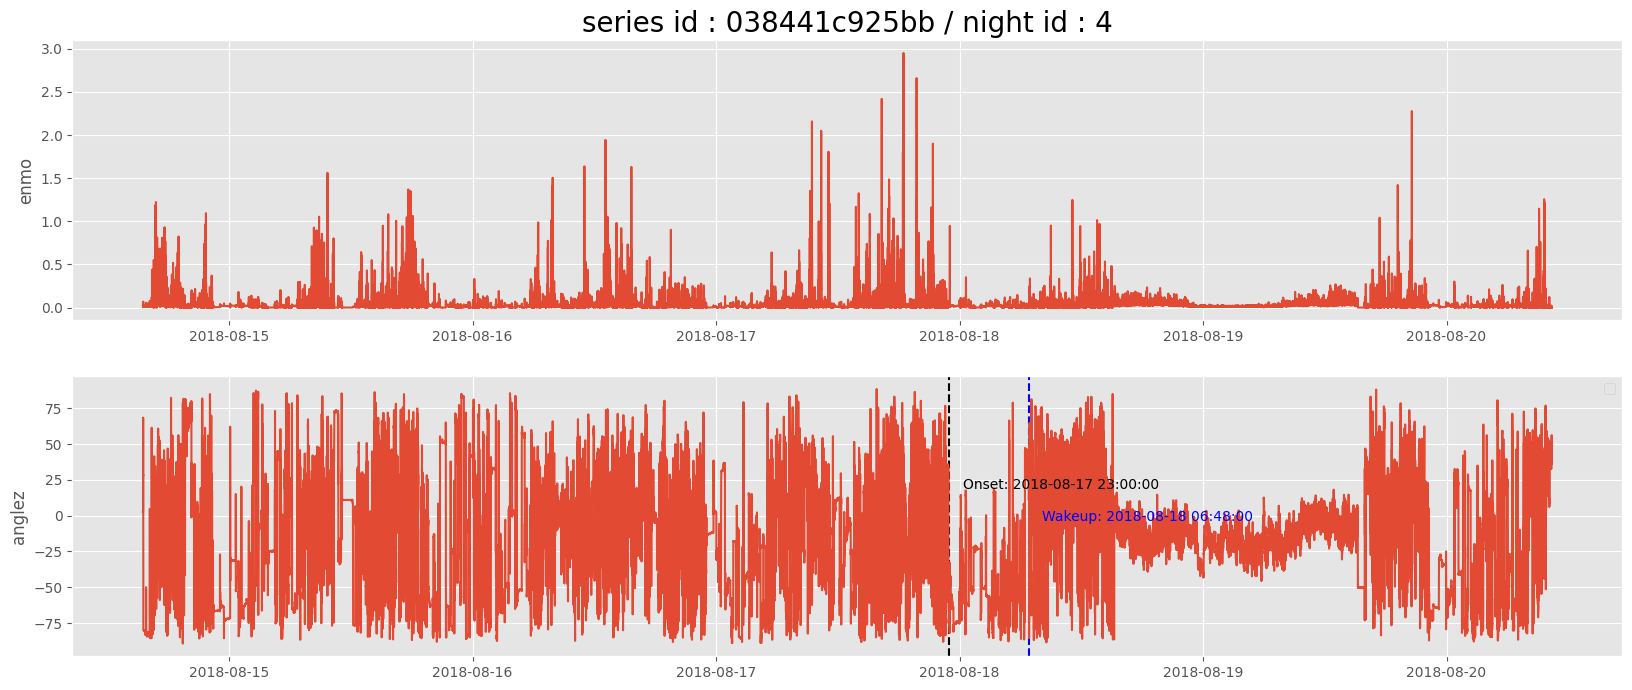

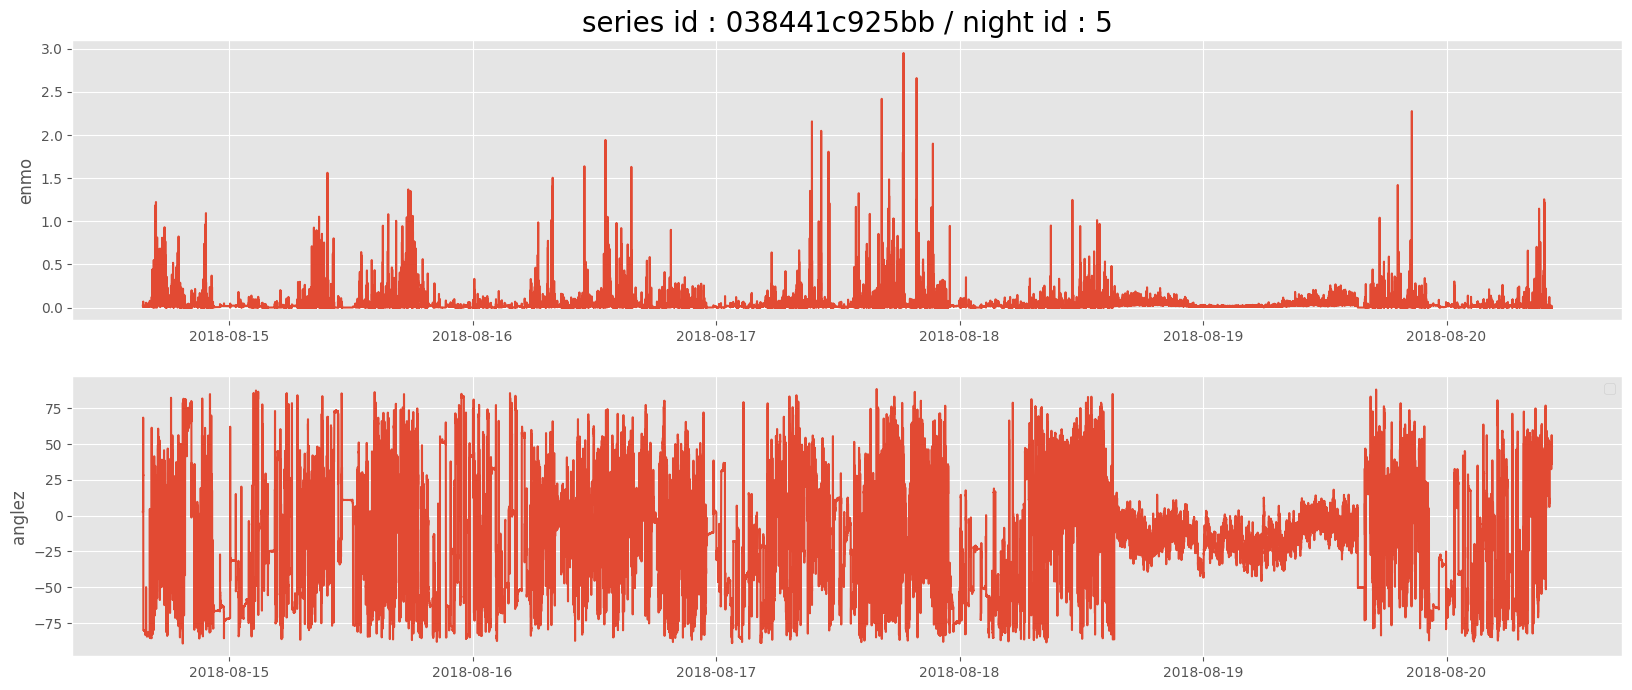

In [8]:
visualizer = CMIDataVisualizer(
    series_data=train_series,
    events_data=train_events
)

series_id = train_series.series_id.unique()[0]
for night_id in range(1,6):
    visualizer.plot_events(
        series_id=series_id,
        night_id=night_id
    )

In [9]:
print(train_events)

                              series_id  night   event      step
timestamp                                                       
2018-08-14 22:26:00-04:00  038441c925bb      1   onset    4992.0
2018-08-15 06:41:00-04:00  038441c925bb      1  wakeup   10932.0
2018-08-15 19:37:00-04:00  038441c925bb      2   onset   20244.0
2018-08-16 05:41:00-04:00  038441c925bb      2  wakeup   27492.0
2018-08-16 23:03:00-04:00  038441c925bb      3   onset   39996.0
...                                 ...    ...     ...       ...
2017-09-05 09:26:00-04:00  fe90110788d2     32  wakeup  547152.0
2017-09-05 22:30:00-04:00  fe90110788d2     33   onset  556560.0
2017-09-06 04:07:00-04:00  fe90110788d2     33  wakeup  560604.0
2017-09-06 23:35:00-04:00  fe90110788d2     34   onset  574620.0
2017-09-07 09:17:00-04:00  fe90110788d2     34  wakeup  581604.0

[9585 rows x 4 columns]


In [10]:
full_data = train_series.merge(train_events[["event","step"]],on="step",how="left")
print("Left Merge of the train_series with the train_events where on='step' and how='left'")
print(full_data)
print("Left Merge data where event is forward fill")
full_data["event"] = full_data["event"].ffill()
print(full_data)
print("Left Merge data where event=NaN then replaced with wakeup")
full_data["event"] = full_data["event"].fillna("wakeup")
print(full_data)

Left Merge of the train_series with the train_events where on='step' and how='left'
           series_id     step     anglez      enmo   event
0       038441c925bb      0.0   2.636719  0.021698     NaN
1       038441c925bb      1.0   2.636719  0.021500     NaN
2       038441c925bb      2.0   2.636719  0.021606     NaN
3       038441c925bb      3.0   2.636719  0.021301     NaN
4       038441c925bb      4.0   2.636719  0.021500     NaN
...              ...      ...        ...       ...     ...
100659  038441c925bb  99995.0  47.781250  0.005699     NaN
100660  038441c925bb  99996.0  48.718750  0.000300  wakeup
100661  038441c925bb  99997.0  48.906250  0.000000     NaN
100662  038441c925bb  99998.0  48.781250  0.000100     NaN
100663  038441c925bb  99999.0  48.781250  0.000000     NaN

[100664 rows x 5 columns]
Left Merge data where event is forward fill
           series_id     step     anglez      enmo   event
0       038441c925bb      0.0   2.636719  0.021698     NaN
1       038441c925b

## CMI Train the DataSet

In [11]:
class CMITrainDataset(Dataset):
    
    def __init__(self, series_data, events_data):
        full_data = series_data.merge(events_data[["event","step"]],on="step",how="left")
        full_data["event"] = full_data["event"].ffill().fillna("wakeup")
        full_data["event"] = full_data["event"].map({"wakeup":0, "onset":1})
        
        self.features = full_data[["anglez","enmo"]]
        self.targets = full_data["event"]
    
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, index):
        features = torch.tensor(self.features.iloc[index], dtype = torch.float32)
        target = torch.tensor(self.targets.iloc[index], dtype = torch.int64)
        return features, target

In [12]:
train_dataset = CMITrainDataset(
    series_data = train_series, 
    events_data = train_events
)

### Printing the 0th indexed item

In [13]:
train_dataset.__getitem__(0)

(tensor([2.6367, 0.0217]), tensor(0))

## Load the train dataset

In [14]:
train_dataloader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)

## Initialize the train dataset with the Iterator and print the values

In [15]:
next(iter(train_dataloader))

[tensor([[ 5.5531e+01,  1.9153e-01],
         [-7.0438e+01,  2.6505e-02],
         [-2.9812e+01,  1.1299e-02],
         [-4.5031e+01,  1.7899e-02],
         [-2.5656e+01,  8.0032e-03],
         [-7.6625e+01,  1.3000e-02],
         [-5.0219e+01,  0.0000e+00],
         [-2.8484e+01,  1.5404e-02],
         [ 2.0469e+00,  1.6693e-02],
         [-6.4125e+01,  2.6001e-02],
         [ 1.3703e+01,  0.0000e+00],
         [-3.9594e+01,  1.6003e-03],
         [-7.5875e+01,  1.1597e-02],
         [ 7.5000e+00,  4.4629e-01],
         [ 3.6438e+01,  8.3130e-02],
         [-2.9031e+01,  1.5259e-01],
         [ 7.0781e+00,  3.6011e-02],
         [ 3.6953e+00,  3.7903e-02],
         [-4.4281e+01,  1.0291e-01],
         [ 1.5404e-02,  2.9694e-02],
         [-5.2156e+01,  1.8097e-02],
         [-4.8281e+01,  1.3000e-02],
         [-1.3219e+01,  2.4597e-02],
         [-1.3156e+01,  1.0002e-02],
         [-1.9203e+01,  1.2802e-02],
         [ 2.1094e+01,  1.0002e-04],
         [ 3.7562e+01,  0.0000e+00],
 